<a href="https://colab.research.google.com/github/dougmusser/Balthius_Optimizer/blob/main/Balthius_Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install External Packages

!pip install scikit-optimize

     |████████████████████████████████| 102kB 4.0MB/s 


In [219]:
#@title Imports and utility methods

import io
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import re
import requests
import skopt
import skopt.space
import skopt.utils
import tqdm
import typing
import zipfile
from IPython.display import display
from IPython.display import HTML
from IPython.display import Image

def get_sharpe(returns: pd.Series) -> np.float64:
  '''Returns the sharpe ratio for a series of returns.'''
  return np.sqrt(252) * returns.mean() / returns.std()

def get_calmar(returns: pd.Series) -> float:
  '''Returns Calmar ratio for a series of returns.

  I prefer Calmar since it maximizes the return on invested capital vs the
  downside risk. Shape tends to prefer strategies with low returns since they
  have less volatility.

  This implementation uses the cumulative sum of return instead of the
  geometric mean since this back-test enables the balance to go negative. Risk
  management and position sizing should be done outside of the optimizer.
  '''
  assert isinstance(returns.index.get_level_values(0)[0], pd.Timestamp)
  returns = returns.sort_index(level=0)
  sum_returns = returns.cumsum()
  rolling_max = sum_returns.expanding(min_periods=1).max()
  rolling_dd = rolling_max - sum_returns
  max_rolling_dd = rolling_dd.max()
  if max_rolling_dd <= 0:
    # Reject strategies that don't have draw downs. They're not realistic.
    return 0
  return sum_returns.iloc[-1] / max_rolling_dd


def truncated_calmar(returns: pd.Series, threshold: float=0.6) -> np.float64:
  '''Returns a Calmar ratio with the positive returns truncated.

  This reduces the effect of outliers when optimizing a strategy.
  '''
  positive_returns = returns.loc[returns > 0]
  if positive_returns.empty:
    # No positive returns
    return get_calmar(returns)
  returns = returns.copy()
  # Truncate the largest returns.
  returns.loc[returns > positive_returns.quantile(threshold)] = (
      positive_returns.quantile(threshold))
  return get_calmar(returns)

def get_annualized_mean(returns: pd.Series) -> np.float64:
  '''Get the annualized mean returns.'''
  assert isinstance(returns.index.get_level_values(0)[0], pd.Timestamp)
  start_date = returns.index.get_level_values(0).min()
  end_date = returns.index.get_level_values(0).max()
  num_years = ((end_date - start_date).days / 365)
  # Annualized mean returns is the sum returns divided by the number
  # of years.
  return returns.sum() / num_years

def skopt_gp_minimize(
    space: typing.List[skopt.Space],
    score_returns_fn,
    n_calls=100,
    **get_returns_kwargs):
  '''Run skopt.gp_minimize for a given return scoring function.

  This is a convenience wrapper for the conventions setup in this CoLab.
  '''
  
  with tqdm.trange(n_calls, desc='running gp_minimize') as t:
    @skopt.utils.use_named_args(space)
    def wrapped_objective(**kwargs):
      get_return_args = {}
      get_return_args.update(get_returns_kwargs)
      get_return_args.update(kwargs)
      returns = get_returns(**get_return_args)
      try:
        if returns.empty:
          return 0
        return -score_returns_fn(returns)
      finally:
        t.update()

    return skopt.gp_minimize(
        wrapped_objective, space, n_calls=n_calls, random_state=0, n_jobs=-1)

In [217]:
#@title Download & Parse Cindicator data. Create a method to get the returns given parameters.

# Download Cindicator data
# Insert the URL for Balthius_Weekly_Cindicator_Exports_20210307.zip here.
weekly_cindicator_export_url = 'INSERT URL FOR Balthius_Weekly_Cindicator_Exports_20210307.zip' #@param
if weekly_cindicator_export_url.startswith('INSERT'):
  weekly_cindicator_export_url = (
      input('Input Balthius_Weekly_Cindicator_Exports_20210307.zip URL'))
response = requests.get(weekly_cindicator_export_url, stream=True)
assert response.status_code == 200
zip_bytes = response.raw.read()

# Parse Cindicator data
option_data = []
with zipfile.ZipFile(io.BytesIO(zip_bytes)) as zf:
  for idx, f in enumerate(zf.filelist):
    match = re.match(
        r'Balthius ([A-Z][A-Z][A-Z]+) (\dpct OTM|ATM) (\d) Week Exp '
        r'(\d{4}-\d{2}-\d{2})\.csv', f.filename)
    if not match:
      raise Exception(f'Unexpected filename: {f.filename}')
    underlying_symbol, trade_target, week_exp, data_date = match.groups()

    # Process trade_target
    trade_target_pct_match = re.match(r'(\d)pct OTM', trade_target)
    if trade_target == 'ATM':
      strike_pct = 0
    elif trade_target_pct_match:
      strike_pct = int(trade_target_pct_match.groups()[0])
    else:
      raise Exception(f'Unexpected trade_target={trade_target}')
    # Process week_exp
    week_exp = int(week_exp)
    # Process data_date
    data_date = pd.Timestamp(data_date).normalize()

    with zf.open(f) as option_csv_content:
      option_data_part = pd.read_csv(
          option_csv_content, parse_dates=['Week Starting'],
          index_col=['Week Starting'])
      # print(option_data_part.columns)
    # Reduce option_data_part to the columns of interest - also ensures the
    # columns of interest are present in the DataFrame.
    # Rename the columns to improve readability.
    # Assign the filename identifiers to the DataFrame.
    option_data.append(
      option_data_part[[
        'Open', 'Gap', 'ESC', 'ESF', 'ECC', 'BEF', 'PSC', 'PEF',
        'CStrike', 'COC1', 'COH1',
        'PStrike', 'POC1', 'POH1',
      ]].rename(columns=dict(
          Open='underlying_open', Gap='underlying_gap',
          CStrike='c_strike', PStrike='put_strike')
      ).assign(
        underlying_symbol=underlying_symbol
      ).assign(
        strike_pct=strike_pct
      ).assign(
        week_exp=week_exp
      ).assign(
        data_date=data_date
      ).set_index(
          ['underlying_symbol', 'strike_pct', 'week_exp'], append=True
      ))
option_data = pd.concat(option_data).sort_index()
# Ensure there are no duplicates
assert not option_data.index.duplicated().any()
display(option_data.head(2))
display(f'option_data length: {len(option_data)}')

#@title Extract Cindicator indicators from a random slice since the indicators are duplicated within the spreadsheet
indicators = option_data.loc[
  pd.IndexSlice[:, 'SPY', 0, 1],
  ['ESC', 'ESF', 'ECC', 'BEF', 'PSC', 'PEF']
].copy()
indicators = indicators.set_index(
    indicators.index.get_level_values('Week Starting')).sort_index()
assert not indicators.index.duplicated().any()
# Calculate indicator changes. Use changes of the log of the indicators instead
# of percentage changes to minimize outliers. Expect all indicators to be > 1,
# otherwise log will have issues. If this ever happens this code will need to
# special-case handle zero values.
assert (indicators > 0).all().all()
indicator_changes = np.log(indicators).sub(np.log(indicators).shift(1)).dropna()
indicator_changes.head(2)

def get_returns(
    symbol, esc_weight, esf_weight, ecc_weight, bef_weight, psc_weight,
    pef_weight, strike_pct, week_exp,
    # ratio_of_balance_to_trade,
    last_week_weight, buy_puts_when_indicator_is_negative,
    call_sell_trigger_pct, put_sell_trigger_pct):
  '''Compute the option returns for a given set of parameters.

  This uses the indicator_changes values above.
  '''

  # Computed the weighted indicator.
  permutation_indicator = (
    (indicator_changes['ESC'] * esc_weight)
    + (indicator_changes['ESF'] * esf_weight)
    + (indicator_changes['ECC'] * ecc_weight)
    + (indicator_changes['BEF'] * bef_weight)
    + (indicator_changes['PSC'] * psc_weight)
    + (indicator_changes['PEF'] * pef_weight))
  permutation_indicator = (
      permutation_indicator +
      permutation_indicator.shift(1).mul(last_week_weight)).dropna()
  # Join the weighted indicators with the historical option data to enable
  # applying the indicator results below. We can't use the indicator values
  # in the option_data data frame since it's difficult to apply the
  # last_week_weight parameter in that fashion.
  option_data_with_indicators = option_data.loc[
    pd.IndexSlice[
      option_data.index.get_level_values('Week Starting').isin(
          permutation_indicator.index),
      symbol, strike_pct:strike_pct, week_exp:week_exp]]
  option_data_with_indicators = (
      option_data_with_indicators.assign(
          indicator=permutation_indicator.loc[
            option_data_with_indicators.index.get_level_values('Week Starting')
          ].values))

  # Start off with assuming zero returns (no trading) for each week.
  returns = pd.Series(0, option_data_with_indicators.index)

  # Apply the call on close returns where the indicator is positive.
  returns.loc[option_data_with_indicators['indicator'] > 0] = (
      option_data_with_indicators['COC1'])
  # Apply the call sell trigger where the indicator is positive when the option
  # high return was at least as high as call_sell_trigger_pct. If the option
  # high didn't meet call_sell_trigger_pct then the COC1 value above is used
  # for the return.
  if call_sell_trigger_pct:
    returns.loc[
        (option_data_with_indicators['indicator'] > 0)
        & (option_data_with_indicators['COH1'] >= call_sell_trigger_pct)
    ] = call_sell_trigger_pct
  # This back-tests puts depending on buy_puts_when_indicator_is_negative.
  if buy_puts_when_indicator_is_negative:
    # Apply the put on close returns where the indicator is negative.
    returns.loc[option_data_with_indicators['indicator'] < 0] = (
        option_data_with_indicators['POC1'])
    # Apply the put sell trigger where the indicator is negative when the option
    # high return was at least as high as put_sell_trigger_pct. If the option
    # high didn't meet put_sell_trigger_pct then POC1 value above is used for
    # the return.
    if put_sell_trigger_pct:
      returns.loc[
        (option_data_with_indicators['indicator'] < 0)
        & (option_data_with_indicators['POH1'] >= put_sell_trigger_pct)
      ] = put_sell_trigger_pct
  # Remove strange values.
  returns.loc[np.isinf(returns)] = None
  return returns

Input Balthius_Weekly_Cindicator_Exports_20210307.zip URLhttps://cdn.discordapp.com/attachments/786492289236205618/818166051966550046/Balthius_Weekly_Cindicator_Exports_20210307.zip


underlying_open  \
Week Starting underlying_symbol strike_pct week_exp                    
2019-12-09    IWM               0          1                  162.75   
                                           2                  162.75   

                                                     underlying_gap  ESC  ESF  \
Week Starting underlying_symbol strike_pct week_exp                             
2019-12-09    IWM               0          1                  -0.07   44   47   
                                           2                  -0.07   44   47   

                                                     ECC  BEF  PSC  PEF  \
Week Starting underlying_symbol strike_pct week_exp                       
2019-12-09    IWM               0          1          59   47   48   44   
                                           2          59   47   48   44   

                                                     c_strike  COC1  COH1  \
Week Starting underlying_symbol strike_pct week_exp                         
2019-12-09    IWM               0          1              163 -0.70  1.16   
                                           2              163 -0.37  0.74   

                                                     put_strike  POC1  POH1  \
Week Starting underlying_symbol strike_pct week_exp                           
2019-12-09    IWM               0          1                163 -0.98  0.37   
                                           2                163 -0.38  0.26   

                                                     data_date  
Week Starting underlying_symbol strike_pct week_exp             
2019-12-09    IWM               0          1        2021-03-07  
                                           2        2021-03-07

'option_data length: 1040'

,annualized_mean,calmar,sharpe
underlying_symbol,,,
IWM,-24%,-5%,-0.1
QQQ,948%,226%,2.2
SPY,331%,74%,0.8


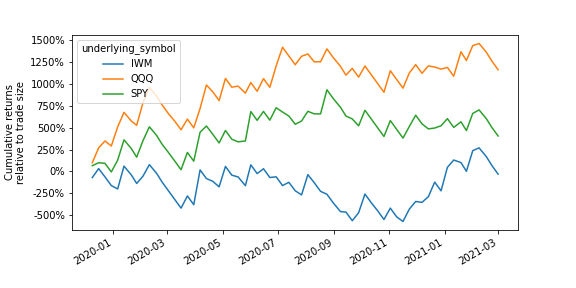

,annualized_mean,calmar,sharpe,annualized_mean_vs_no_indicator,calmar_vs_no_indicator,sharpe_vs_no_indicator
underlying_symbol,,,,,,
IWM,"1,079%",553%,3.2,"1,103%",558%,3.2
SPY,"1,431%","1,070%",4.3,"1,100%",996%,3.5


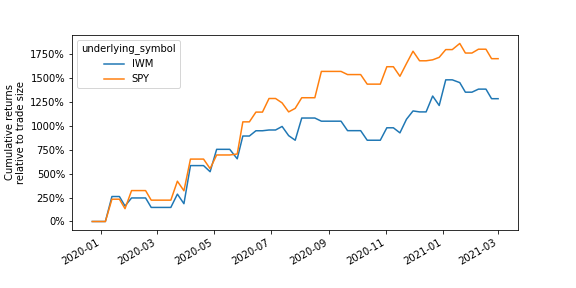

,annualized_mean,calmar,sharpe,annualized_mean_vs_call_only,calmar_vs_call_only,sharpe_vs_call_only
underlying_symbol,,,,,,
IWM,"1,423%",272%,3.0,344%,-281%,-0.2
SPY,"1,267%",455%,2.9,-164%,-615%,-1.4


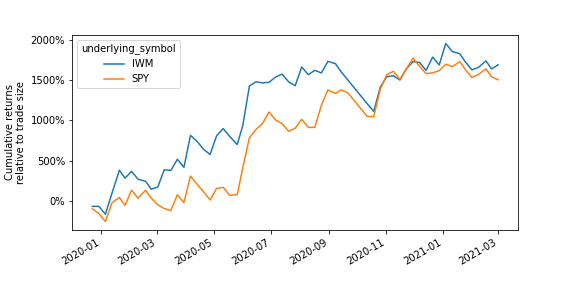

,annualized_mean,calmar,sharpe,annualized_mean_vs_call_only,calmar_vs_call_only,sharpe_vs_call_only
underlying_symbol,,,,,,
IWM,"1,447%",550%,3.0,368%,-3%,-0.2
SPY,"1,844%",419%,3.5,414%,-651%,-0.8


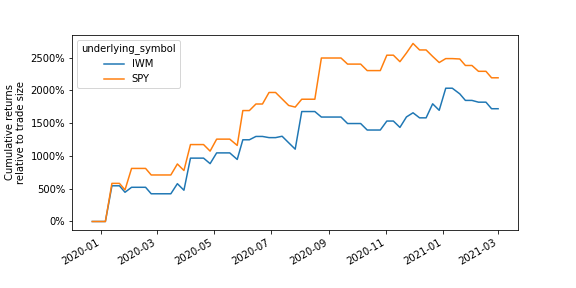

,annualized_mean,calmar,sharpe,annualized_mean_vs_call_only,calmar_vs_call_only,sharpe_vs_call_only
underlying_symbol,,,,,,
IWM,874%,866%,3.9,-205%,313%,0.8
SPY,873%,805%,4.3,-558%,-265%,0.0


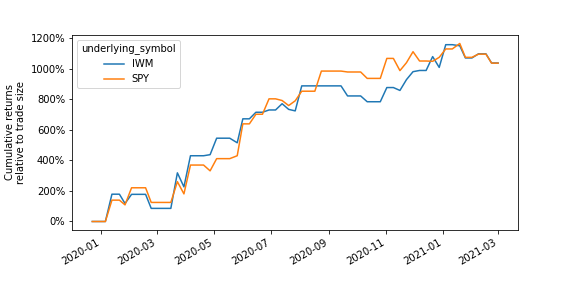

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [6]:
#@title Compare the results of various strategies to explore how different configurations affect returns. This is a prelude into using a risk-adjusted optimizer to find an ideal trading parameter setting.

def disply_trading_results(
    title: str, desc: str, symbols=('SPY', 'IWM'),
    returns: pd.Series=None,
    esc_weight=1, esf_weight=1, ecc_weight=1, bef_weight=1, psc_weight=1,
    pef_weight=1, strike_pct=0, week_exp=1, last_week_weight=0,
    buy_puts_when_indicator_is_negative=False, call_sell_trigger_pct=0,
    put_sell_trigger_pct=0,
    comp_benchmarks: pd.DataFrame=None,
    comp_benchmarks_name: str=''):

  if returns is None:
    # Compute returns if not provided
    returns = pd.concat(
      get_returns(
          symbol=symbol, esc_weight=esc_weight, esf_weight=esf_weight,
          ecc_weight=ecc_weight, bef_weight=bef_weight, psc_weight=psc_weight,
          pef_weight=pef_weight, strike_pct=strike_pct, week_exp=week_exp,
          last_week_weight=last_week_weight,
          buy_puts_when_indicator_is_negative=buy_puts_when_indicator_is_negative,
          call_sell_trigger_pct=call_sell_trigger_pct,
          put_sell_trigger_pct=put_sell_trigger_pct)
      for symbol in symbols)
  plt.figure()
  ax = (
      returns.droplevel(['strike_pct', 'week_exp']).unstack('underlying_symbol')
      .cumsum()
  ).plot(figsize=(8, 4))
  ax.xaxis.set_label_text('')
  ax.yaxis.set_label_text('Cumulative returns\nrelative to trade size')
  ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
  imgbuf = io.BytesIO()
  plt.savefig(imgbuf)
  imgbuf.flush()
  plt.close()
  benchmarks = (
      returns.groupby(level='underlying_symbol')
      .agg(annualized_mean=get_annualized_mean, calmar=get_calmar,
              sharpe=get_sharpe))
  benchmarks_for_display = benchmarks.copy()
  if comp_benchmarks is not None:
    comp_benchmarks = benchmarks.sub(comp_benchmarks)
    comp_benchmarks_for_display = comp_benchmarks.copy()
  for col, format in {
      'annualized_mean': '{:,.0%}',
      'calmar': '{:,.0%}',
      'sharpe': '{:,.1f}'}.items():
    benchmarks_for_display[col] = benchmarks_for_display[col].map(format.format)
    if comp_benchmarks is not None:
      comp_benchmarks_for_display[col] = (
          comp_benchmarks_for_display[col].map(format.format))
  if comp_benchmarks is not None:
    assert comp_benchmarks_name
    benchmarks_for_display = benchmarks_for_display.join(
        comp_benchmarks_for_display, rsuffix=f'_vs_{comp_benchmarks_name}')
  display(
      HTML(f'<h2>{title}</h2>{desc}'),
      benchmarks_for_display,
      Image(imgbuf.getvalue()),
      HTML('<hr>'))
  return benchmarks

no_indicator_benchmarks = disply_trading_results(
    title='No indicators, Always buy calls',
    desc=('The results of not using any indicators.\n'
          'Cindicator results are compared to these results'),
    returns=option_data.loc[pd.IndexSlice[:, :, 0, 1], 'COC1'])
call_only_benchmarks = disply_trading_results(
    title='Baseline Indicator Strategy',
    desc=(
        'Buy 1 Week ATM calls when indicator mean is postitive<p>'
        'The indicators demonstrate significant improvements to returns.<p>'
        'The returns are higher as measured in mean returns and risk '
        'adjusted Calmar and shapre returns.'
        '<h3>Analysis</h3>'
        'Use the indicators as a signal for trading vs always buying calls.'),
    comp_benchmarks=no_indicator_benchmarks,
    comp_benchmarks_name='no_indicator')
disply_trading_results(
    title='Baseline Indicator Strategy with Puts',
    desc=(
        'Buy 1 Week ATM calls when indicator mean is postitive<br>'
        'and 1 week ATM puts when indicator mean is negative<p/>'
        'Adding puts improves IWM reutrns but reduces SPY returns.<br>'
        'This comes at the cost of <b>increased risk</b> as measured by Calmar '
        'sharpe ratios.<br>'
        'Traing puts means reducing position sizes to account for risk '
        'increase'
        '<h3>Analysis</h3>'
        '<b>Do not trade puts</b>, they always increase risk and sometimes '
        'increase returns'),
    buy_puts_when_indicator_is_negative=True,
    comp_benchmarks=call_only_benchmarks,
    comp_benchmarks_name='call_only')
disply_trading_results(
    title='Calls when indicator >0 strike 1% of underlying price',
    desc=(
        'This approach increases overall all returns but '
        '<b>decreases</b> returns when accounting for risk as measured<br>'
        'by Calmar and sharpe. It would require reduced position sizes to '
        'trade.'
        '<h3>Analysis</h3>'
        'Do not use due to increased risk.'),
    strike_pct=1,
    comp_benchmarks=call_only_benchmarks,
    comp_benchmarks_name='call_only')
disply_trading_results(
    title='Calls when indicator >0, ATM options, 2-week expiration',
    desc=(
        'This approach decreaes returns and varies based on risk adjusted '
        'Calmar and sharpe returns.<br>'
        '<h3>Analysis</h3>'
        'Do not use. This does not improve on the baseline indicator strategy.'),
    week_exp=2,
    comp_benchmarks=call_only_benchmarks,
    comp_benchmarks_name='call_only')
None # Don't display the return value of the last line in the cell

In [ ]:
optimize_space = [
  skopt.space.Real(-1, 1, name='esc_weight'),
  skopt.space.Real(-1, 1, name='esf_weight'),
  skopt.space.Real(-1, 1, name='ecc_weight'),
  skopt.space.Real(-1, 1, name='bef_weight'),
  skopt.space.Real(-1, 1, name='psc_weight'),
  skopt.space.Real(-1, 1, name='pef_weight'),
  skopt.space.Real(0, 1, name='last_week_weight'),
  skopt.space.Real(0, 8, name='call_sell_trigger_pct'),
]

hard_coded_params = dict(
    symbol='SPY',
    strike_pct=0,
    week_exp=1,
    buy_puts_when_indicator_is_negative=False,
    put_sell_trigger_pct=0)

res_gp = skopt_gp_minimize(
    optimize_space, truncated_calmar, n_calls=300,
    **hard_coded_params)

running gp_minimize:  16%|█▌        | 48/300 [00:27<03:59,  1.05it/s]/home/dougmusser/py38/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
running gp_minimize:  47%|████▋     | 141/300 [03:34<07:45,  2.92s/it]/home/dougmusser/py38/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
running gp_minimize:  47%|████▋     | 142/300 [03:37<08:13,  3.12s/it]/home/dougmusser/py38/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
running gp_minimize:  48%|████▊     | 143/300 [03:41<08:15,  3.16s/it]/home/dougmusser/py38/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objectiv

,esc_weight,esf_weight,ecc_weight,bef_weight,psc_weight,pef_weight,last_week_weight,call_sell_trigger_pct,mean_returns,calmar,truncated_calmar,sharpe
52,0.871542,-1.000000,0.291499,1.00000,0.030287,-0.012055,0.000000,6.802868,0.268730,10.647799,7.550943,4.167964
7,0.163701,-0.171263,-0.050605,0.24702,-0.323985,0.349505,0.317202,6.226764,0.308254,9.808081,7.331313,4.596313
68,1.000000,-1.000000,1.000000,1.00000,-0.717141,-0.277706,0.000000,8.000000,0.281111,8.855000,6.205000,4.271734
94,0.845694,-1.000000,0.043767,1.00000,0.083884,0.532541,0.000000,3.990180,0.261429,10.358491,6.169811,4.012139
86,1.000000,-1.000000,1.000000,1.00000,-0.584604,0.068016,0.000000,8.000000,0.277778,8.750000,6.100000,4.205778


,annualized_mean,calmar,sharpe,annualized_mean_vs_non-optimized,calmar_vs_non-optimized,sharpe_vs_non-optimized
underlying_symbol,,,,,,
SPY,"1,424%","1,065%",4.2,-7%,-5%,-0.1


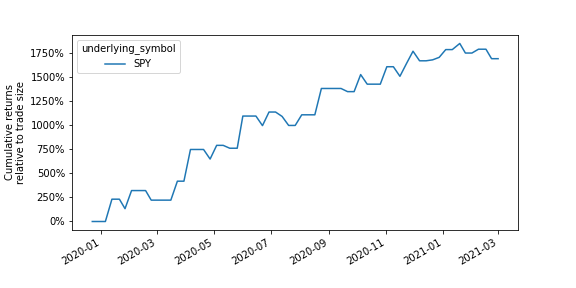

,annualized_mean,calmar,sharpe
underlying_symbol,,,
SPY,14.238364,10.647799,4.167964


<Figure size 432x288 with 0 Axes>

In [109]:
optimize_results = [
  dict(zip((s.name for s in optimize_space), i))
  for i in res_gp.x_iters]
for res in optimize_results:
  get_returns_args = {}
  get_returns_args.update(hard_coded_params)
  get_returns_args.update(res)
  returns = get_returns(**get_returns_args)
  res['mean_returns'] = returns.mean()
  res['calmar'] = get_calmar(returns)
  res['truncated_calmar'] = truncated_calmar(returns)
  res['sharpe'] = get_sharpe(returns)
  res['returns'] = returns
optimize_results = pd.DataFrame.from_records(optimize_results).sort_values(
    'truncated_calmar', ascending=False)
display(
    HTML('<h1>ATM 1 Week Call Only Optimized Returns</h1>'),
    HTML('<h2>Best scoring optimized parameters</h2>'),
    optimize_results.drop('returns', axis=1).head(5),
    HTML('<hr>'),)
disply_trading_results(
    title='Returns Deep Dive',
    desc='',
    returns=optimize_results.iloc[0].returns,
    comp_benchmarks=call_only_benchmarks,
    comp_benchmarks_name='non_optimized')

In [ ]:
import threading

symbol = 'SPY'

min_indicator_weight = -10
max_indicator_weight = 10
space = [
  skopt.space.Real(-1, 1, name='esc_weight'),
  skopt.space.Real(-1, 1, name='esf_weight'),
  skopt.space.Real(-1, 1, name='ecc_weight'),
  skopt.space.Real(-1, 1, name='bef_weight'),
  skopt.space.Real(-1, 1, name='psc_weight'),
  skopt.space.Real(-1, 1, name='pef_weight'),
  skopt.space.Categorical(
      option_data.index.get_level_values('strike_pct').unique(),
      name='strike_pct'),
  skopt.space.Categorical(
      option_data.index.get_level_values('week_exp').unique(),
      name='week_exp'),
  # skopt.space.Real(0, 1, name='ratio_of_balance_to_trade'),
  skopt.space.Real(0, 1, name='last_week_weight'),
  # skopt.space.Categorical(
  #   [False, True],
  #   name='buy_puts_when_indicator_is_negative'),
  skopt.space.Real(0, 8, name='call_sell_trigger_pct'),
  # skopt.space.Real(
  #     0.1, 6,
  #     name='put_sell_trigger_pct')
]




call_times.clear()
@skopt.utils.use_named_args(space)
def objective(**kwargs):
  return wrapped_objective(get_sharpe, **kwargs)
  # last_args.update(kwargs)
  # ret = get_returns(symbol=symbol, **kwargs)
  # if ret.empty:
  #   return 0
  # ret = -get_sharpe(ret)
  # returns.append(ret)
  # return ret

@skopt.utils.use_named_args(space)
def calmar_objective(**kwargs):
  return wrapped_objective(get_calmar, **kwargs)

@skopt.utils.use_named_args(space)
def calmar_sum_returns_objective(**kwargs):
  return wrapped_objective(
      get_calmar_sum_returns,
      quarterly_median_of_returns=True, **kwargs)
  
def custom_returns(returns: pd.Series) -> np.float64:
  positive_returns = returns.loc[returns > 0]
  if positive_returns.empty:
    return returns.mean()
  returns = returns.copy()
  # Prevent the largest returns from dominating the results
  returns.loc[returns > positive_returns.quantile(.6)] = (
      positive_returns.quantile(.6))
  return get_calmar_sum_returns(returns)

@skopt.utils.use_named_args(space)
def custom_objective(**kwargs):
  return wrapped_objective(custom_returns, **kwargs)

def gp_minimize():
  return skopt.gp_minimize(
    custom_objective, space, n_calls=800, random_state=0, n_jobs=-1)

thread = threading.Thread(target=gp_minimize)
thread.start()

# res_gp = skopt.gp_minimize(
#     custom_objective, space, n_calls=500, random_state=0, n_jobs=-1)
# pd.Series(res_gp.func_vals).mul(-1).plot(
#     title=(f'shappe vs iteration: symbol={symbol} '
#            f'final opt={-res_gp.fun:.02f}'))

In [ ]:
pd.Series(res_gp.func_vals).mul(-1).plot(
    title=(f'objective vs iteration: symbol={symbol} '
           f'final sharpe={-res_gp.fun:.02f}'))

<AxesSubplot:title={'center':'optimization'}>

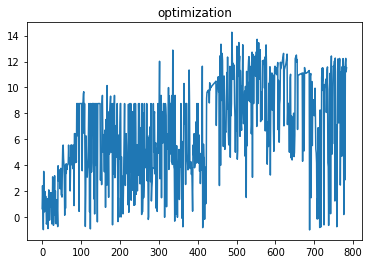

In [ ]:
pd.Series(returns).mul(-1).plot(title='optimization')

In [ ]:
results = pd.DataFrame(
    call_args,
    # columns=[f.name for f in space],
).join(
    pd.Series(
        get_returns(
            symbol=symbol,
            buy_puts_when_indicator_is_negative=False,
            put_sell_trigger_pct=0,
            **ca).mean() * 52 for ca in call_args).rename('annual_return')
).join(
    pd.Series(returns).mul(-1).rename('objective_to_maximize')).sort_values(
        'objective_to_maximize', ascending=False).head(15)
results

,esc_weight,esf_weight,ecc_weight,bef_weight,psc_weight,pef_weight,strike_pct,week_exp,last_week_weight,call_sell_trigger_pct,annual_return,objective_to_maximize
488,0.991142,0.510416,0.017200,-0.065350,-0.621766,0.898705,0,1,0.027699,0.716604,11.766111,14.255096
553,1.000000,0.235436,0.108695,0.082696,-0.390361,1.000000,0,1,0.063250,0.668145,11.317650,13.711768
506,1.000000,0.504838,-0.010086,-0.071524,-0.610828,0.852833,0,1,0.009009,0.699669,11.111271,13.461732
557,0.869502,0.236155,-0.010226,0.114403,-0.375777,1.000000,0,1,0.069134,0.684223,11.097936,13.445577
460,1.000000,0.522000,-0.057030,-0.068334,-0.612650,0.864306,0,1,0.044689,0.679798,11.006622,13.334946
516,1.000000,0.484735,0.043630,0.159699,-0.629049,0.934357,0,1,0.045685,0.678147,10.972565,13.293685
576,0.751111,0.214463,0.019535,0.320443,-0.347141,1.000000,0,1,0.070646,0.705808,10.960765,13.279389
501,1.000000,0.497747,0.042512,0.060118,-0.601337,0.863526,0,1,0.031440,0.673712,10.881031,13.182788
561,1.000000,0.232602,0.153474,0.094052,-0.447662,1.000000,0,1,0.077074,0.690519,10.657895,12.912450
336,0.852011,0.515018,-0.127446,-0.179340,-0.676702,0.907032,0,1,0.025380,0.689153,10.630842,12.879674


num returns: 784


False    35
True     28
dtype: int64

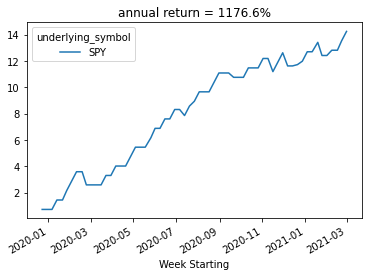

In [ ]:
assert len(returns) == len(call_args)
results = pd.Series(dict(zip(returns, call_args))).sort_index()

print(f'num returns: {len(returns)}')

r = get_returns(
    symbol=symbol,
    buy_puts_when_indicator_is_negative=False,
    put_sell_trigger_pct=0,
    **results.iloc[0]).sort_index()#.loc[pd.Timestamp('2020-09-01'):]
(
  r
  .droplevel('week_exp')
  .droplevel('strike_pct')
  .cumsum()
  .unstack('underlying_symbol')
).plot(title=f'annual return = {r.mean() * 52:0.1%}')
(r == 0).value_counts()

In [ ]:
pd.Series(
    get_returns(
        symbol=symbol,
        buy_puts_when_indicator_is_negative=False,
        put_sell_trigger_pct=0,
        **i).mean() * 52
    for i in call_args[-100:]).mean()

8.831530212421997